In [ ]:
%run ./utils.ipynb

import cv2 as cv
from collections import Counter
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

/mnt/802AC4E62AC4D9F4/tp fundamentos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Análisis exploratorio del dataset

Se cuentan y muestran los porcentajes de cada tipo de soldadura.

Casting to class labels: 100%|██████████| 26666/26666 [00:00<00:00, 569500.34 examples/s]


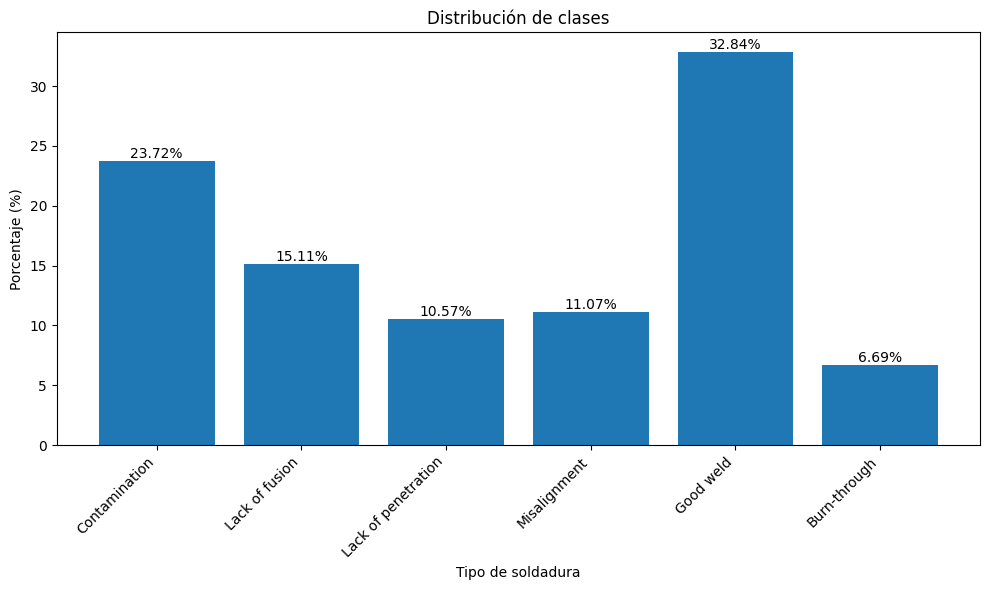

In [ ]:
train_dataset = load_image_dataset("train")
class_names = ["Good weld", "Burn-through", "Contamination", "Lack of fusion", "Misalignment", "Lack of penetration"]
image_counter = Counter(train_dataset["label"])
total_images = len(train_dataset)
classes = [class_names[k] for k in image_counter.keys()]
percentages = [v/total_images * 100 for v in image_counter.values()]
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, percentages)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

plt.xlabel('Tipo de soldadura')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución de clases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

a) Se observa que hay desbalance con un máximo de diferencia de 26%.

b) Las técnicas consideradas fueron las de categoria Básica descritas en este _paper_

[Image Data Augmentation Approaches: A
Comprehensive Survey and Future Directions](https://arxiv.org/pdf/2301.02830)

* Image Manipulation (geometric and non-geometric)
* Image Erasing
* Image Mixing

Debido a la naturaleza del problema se decidió descartar aquellas que involucran mezcla de imágenes o eliminación al azar. De la misma forma, se buscó evitar aquellas que desplazasen la zona de interés (como rotación).

Se aplicaron los siguientes métodos
* Flipping (alrededor del eje vertical)
* Resizing
* Noise injection (en forma de variación aleatoria de brillo y contraste)
* Kernel filtering (en forma de un filtro Gaussiano)

Las técnicas fueron aplicadas en el momento previo al entrenamiento de la parte 3 (ver el archivo correspondiente). Para mayor variedad, se permitió combinarlas.

c) Visualización de imágenes

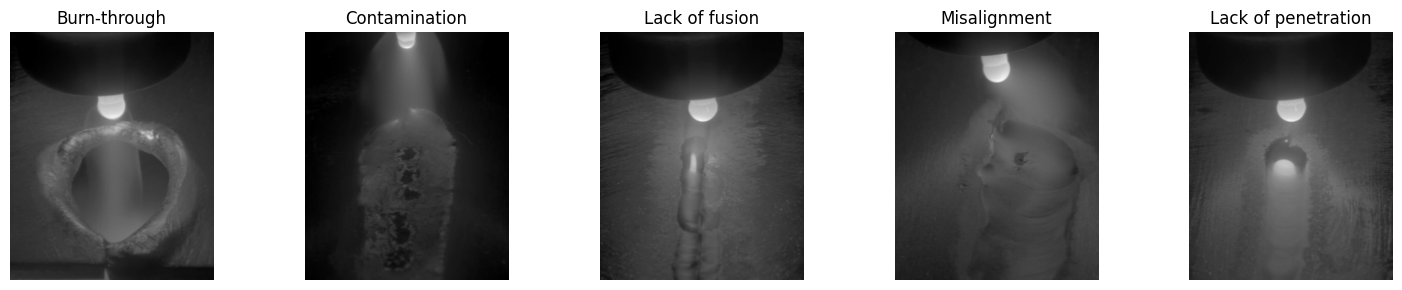

In [ ]:
BURN_THROUGH = "train/170906-144958-Al 2mm/frame_00192.png" 
CONTAMINATION = "train/170815-134756-Al 2mm/frame_00317.png"
LACK_OF_FUSION = "train/170906-151353-Al 2mm/frame_00062.png"
MISALIGNMENT = "train/170904-155523-Al 2mm/frame_01380.png"
LACK_OF_PENETRATION = "train/170906-153326-Al 2mm-part1/frame_00315.png"
LACK_OF_PENETRATION_2 = "train/170904-115503-Al 2mm/frame_00666.png"

faults_images = [BURN_THROUGH, CONTAMINATION, LACK_OF_FUSION, MISALIGNMENT, LACK_OF_PENETRATION]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, (ax, path) in enumerate(zip(axes, faults_images)):
    img = cv.imread(path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{class_names[i+1]}")

plt.tight_layout()
plt.show()

# 2. Algoritmo básico para detección de errores

Se consideró que realizar un único algoritmo de procesamiento para detectar los 5 tipos distintos de errores era demasiado complejo, asi que se optó por definir un algoritmo para cada tipo de error posible, y una lógica básica para agregarlos. No se hizo tanto enfásis en una clasificación perfecta de los errores, sino en permitir una clasificación aceptable en soldaduras buenas y defectuosas.

Se generó un _test_ split reducido a partir del _test_ split original con 100 imágenes con soldaduras defectuosas y 100 imágenes con soldaduras exitosas. Las imágenes defectuosas se eligieron equitativamente respecto de los tipos de defecto (20 de cada uno) y siempre que se pudo se incorporaron ejemplos de distintos casos de soldaduras, también equitativamente.

A continuacion se explica la lógica en la detección de cada tipo de error y los pasos del algoritmo.

## BURN-THROUGH

Estas soldaduras presentan un agujero notorio en el medio, por lo cual se buscó un algoritmo que permitiese aislarlo.

1) Primero se binarizó la imagen (método local, debido a que la iluminación no responde bien a un método global)
2) Luego mediante un SE de tipo elipse se realizó una operación de cerrado agresiva (5 iteraciones). El resultado buscado fue que el agujero se convierta en una gran área (cerrada) negra, para finalmente aplicar el ultimo paso.
3) Se buscaron los componentes conexos y en caso de encontrar uno con un área que supere el umbral, se consideró que se encontró un agujero, y por lo tanto que la soldadura es defectuosa.

In [ ]:

def burn_through_detection(target_img):
    BURN_THROUGH_AREA_THRESHOLD = 150000
    target_img = cv.imread(target_img, cv.IMREAD_GRAYSCALE)
    gray = target_img[300:, :650] 
    bin_img = cv.adaptiveThreshold(
        gray,
        255,
        cv.ADAPTIVE_THRESH_MEAN_C,
        cv.THRESH_BINARY_INV, 
        51,   
        5     
    )
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    binary = cv.morphologyEx(bin_img, cv.MORPH_CLOSE, kernel, iterations=5)
    num_labels, _, stats, _ = cv.connectedComponentsWithStats(binary, connectivity=8)
    for i in range(1, num_labels):
        area = stats[i, cv.CC_STAT_AREA]
        if area > BURN_THROUGH_AREA_THRESHOLD:
            return True
    return False

## CONTAMINATION

Las soldaduras que presentan este defecto muestran una serie de pequeñas manchas. Esto permite identificarlas muy fácilmente mediante un detector de _blobs_ correctamente parametrizado. Si el número de las mismas supera el umbral, se la considera defectuosa.

In [ ]:
def contamination_detection(target_img):  
    CONTAMINATION_THRESHOLD = 5  
    img = cv.imread(target_img, cv.IMREAD_GRAYSCALE)
    h, w = img.shape
    roi = img[h//2:, :] 
    params = cv.SimpleBlobDetector_Params()
    params.filterByColor = True
    params.blobColor = 0  
    params.filterByArea = True
    params.minArea = 50
    params.maxArea = 100000
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    params.minThreshold = 10
    params.maxThreshold = 200
    params.thresholdStep = 10
    detector = cv.SimpleBlobDetector_create(params)
    keypoints = detector.detect(roi)
    if len(keypoints) >= CONTAMINATION_THRESHOLD:
        return True
    return False

## LACK OF FUSION

Estas soldaduras presentan usualmente una línea muy notoria en el medio. Para detectar la misma se aplican los siguientes pasos

1) Un recorte del medio de la imagen (como se conoce la zona de interés se intenta aislarla lo mas posible)
2) Se aplica el algoritmo de Canny para detectar los bordes de la imagen
3) Finalmente, se aplica el algoritmo de Hough sobre el resultado del paso anterior con parámetros estrictos para encontrar la línea deseada. En caso de tener éxito se considera que la soldadura es defectuosa.

Este algoritmo es claramente muy dependiente de la zona analizada, pues las líneas a los costados de una soldadura correcta podrían potencialmente generar falsos positivos.

In [ ]:
def lack_of_fusion_detection(target_img):
    target_img = cv.imread(target_img, cv.IMREAD_GRAYSCALE)
    gray = target_img[500:, 325:475] 
    edges = cv.Canny(
    gray,
    threshold1=10,
    threshold2=30
    )
    lines = cv.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=150,
        minLineLength=250,
        maxLineGap=15
    )
    if lines is not None:
        return True
    else:
        return False

## MISALIGNMENT

Este defecto se manifiesta en forma de líneas con exceso de curvaturas en los bordes de las soldaduras, en vez de las líneas más rectas de una soldadura exitosa.

1) Se aplica un filtro gaussiano como paso previo a aplicar Sobel
2) Se aplica un filtro de Sobel vertical para enfatizar las lineas de soldadura.
3) Se binariza la imagen como paso previo al análisis de contornos
4) Se encuentran los contornos y se los ordena de mayor a menor longitud.
5) Se mantienen solo los tres contornos mas largos (se considera que el contorno deseado debe estar dentro de estos, o bien no existir) y se aplican dos filtros: uno de longitud mínima y uno para verificar que el contorno no se encuentra en un área muy chica (esto es para evitar contornos largos enrollados sobre si mismos).
6) Como ultimo paso, se calcula la solidez (_solidity_) del contorno. Esta es la razón entre el area del contorno respecto del area de su casco convexo (_convex hull_, el elemento convexo más chico que lo contiene). En caso de estar bajo cierto umbral, se considera que el contorno es mas curvo que recto y la soldadura es defectuosa.

In [ ]:
def misalignment_detection(target_img):
    CIRCULARITY_THRESHOLD = 3
    MISALIGNMENT_THRESHOLD = 0.40
    CONTOUR_LENGTH_THRESHOLD = 500
    img = cv.imread(target_img, cv.IMREAD_GRAYSCALE)
    img = img[500:, :] 
    cl1 = cv.GaussianBlur(img, (7,7), 0)
    sobelx_64f = cv.Sobel(cl1, cv.CV_64F, 1, 0, ksize=5)
    sobel_abs = np.uint8(np.absolute(sobelx_64f))
    _, logo_bin = cv.threshold(sobel_abs, 100, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(logo_bin, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    contours = sorted(
            contours,
            key=lambda c: cv.arcLength(c, closed=True),
            reverse=True)
    for cnt in contours[:3]:
        (cx, cy), radius = cv.minEnclosingCircle(cnt)
        diameter = 2 * radius
        arc_length = cv.arcLength(cnt, closed=False)
        if diameter < 1 or arc_length < CONTOUR_LENGTH_THRESHOLD:
            continue
        ratio = arc_length / diameter
        if ratio > CIRCULARITY_THRESHOLD:
            continue
        hull = cv.convexHull(cnt)
        area = cv.contourArea(cnt)
        hull = cv.convexHull(cnt)
        hull_area = cv.contourArea(hull)
        solidity = area / (hull_area + 1e-6)
        if solidity < MISALIGNMENT_THRESHOLD:
            return True
    return False

## LACK OF PENETRATION

Este defecto se puede identificar mediante los surcos resultantes de la soldadura: los mismos son más angostos que una soldadura exitosa. Luego, se buscó un algoritmo que permitiese medir el ancho de los mismos.

1) Primero se aplica CLAHE para incrementar el contraste local.
2) Luego se aplica un filtro de Sobel horizontal 1D a una linea posicionada sobre el surco. Con el filtro se busca resaltar el contraste horizontal y destacar aun más el comienzo y fin del mismo.
3) Los dos picos más altos en los valores resultantes representan el inicio y fin del surco, y la distancia entre ellos es el ancho del surco en pixeles para esa linea.
3) Como último paso se verifica que la longitud no supere un cierto umbral. En ese caso, la soldadura se cataloga como defectuosa.

In [ ]:
def get_line_width(img, middle_row):
    abs_sobel = np.abs(img)
    roi = abs_sobel[middle_row, 200:600]
    peaks, properties = find_peaks(roi, height=np.max(roi)*0.2, distance=80)
    top2 = np.argsort(properties['peak_heights'])[-2:]
    p1, p2 = np.sort(peaks[top2] + 200)
    width = p2 - p1
    return width

def lack_of_penetration_detection(target_img):
    LACK_OF_PENETRATION_THRESHOLD = 200
    target_img = cv.imread(target_img, cv.IMREAD_GRAYSCALE)
    gray = target_img[300:, :] 
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    sobelx = cv.Sobel(enhanced, cv.CV_64F, 1, 0, ksize=5)
    height, _ = gray.shape[:2]
    largest_width = get_line_width(sobelx, 3*height//4)
    return largest_width <= LACK_OF_PENETRATION_THRESHOLD

Como se puede observar, la logica de agregación es trivial: para ser catalogada como correcta, una soldadura debe superar cada uno de los algoritmos descritos arriba. En caso de ser detectada como defectuosa, el primer algoritmo en hacerlo le asigna su etiqueta.

In [ ]:
gold_labels = []
predicted_labels = []
test_dataset = load_image_dataset("test")
for row in test_dataset:
    gold_labels.append(row["label"])
    if burn_through_detection(row["image"]):
        predicted_labels.append(1)
        continue
    if contamination_detection(row["image"]):
        predicted_labels.append(2)
        continue
    if lack_of_fusion_detection(row["image"]):
        predicted_labels.append(3)
        continue
    if misalignment_detection(row["image"]):
        predicted_labels.append(4)
        continue
    if lack_of_penetration_detection(row["image"]):
        predicted_labels.append(5)
        continue
    predicted_labels.append(0)

Casting to class labels: 100%|██████████| 200/200 [00:00<00:00, 128718.86 examples/s]


La matriz de confusión y reportes de clasificación se generan tanto para cada clase considerada por separado como para la división binaria entre soldadura correcta y soldadura defectiva.

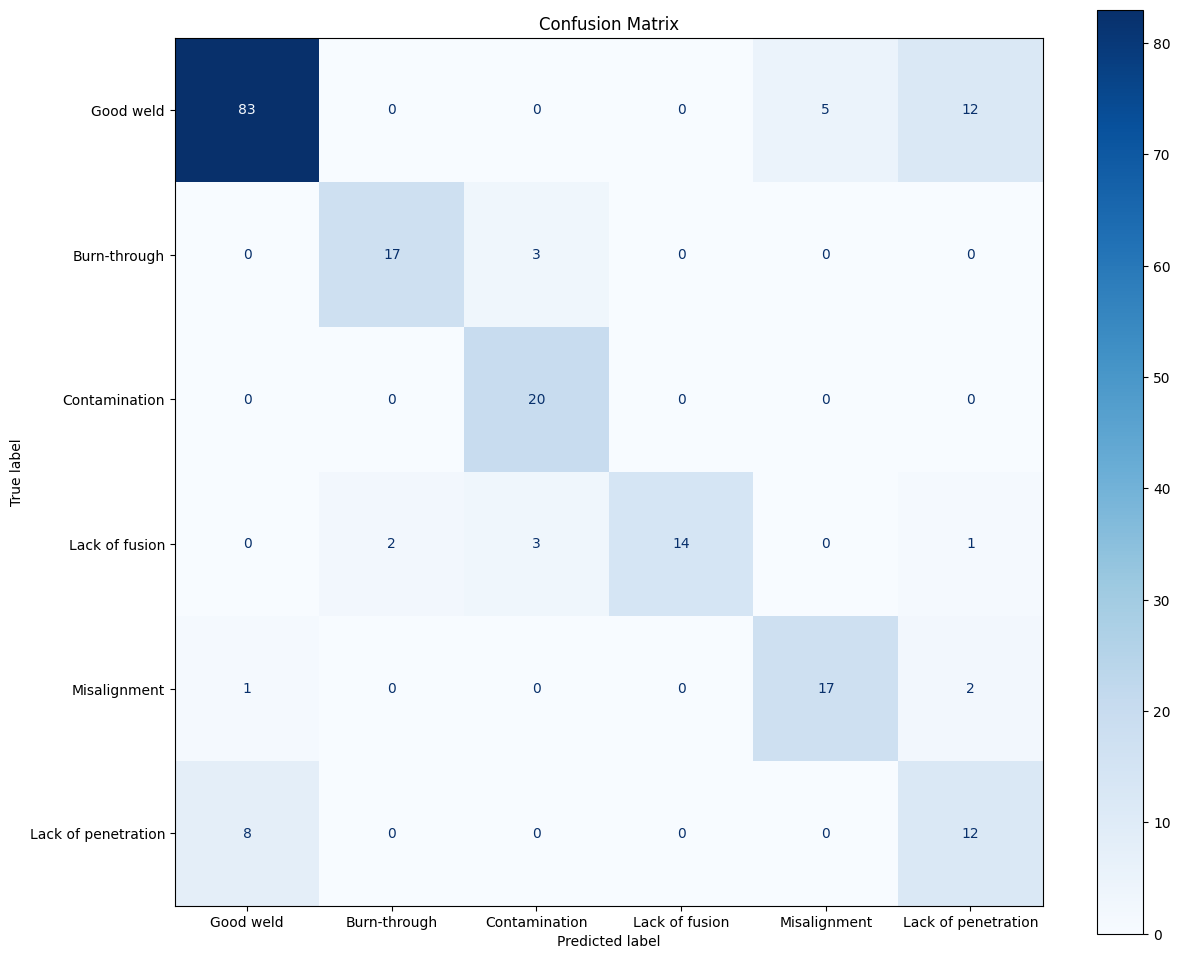

                     precision    recall  f1-score   support

          Good weld       0.90      0.83      0.86       100
       Burn-through       0.89      0.85      0.87        20
      Contamination       0.77      1.00      0.87        20
     Lack of fusion       1.00      0.70      0.82        20
       Misalignment       0.77      0.85      0.81        20
Lack of penetration       0.44      0.60      0.51        20

           accuracy                           0.81       200
          macro avg       0.80      0.80      0.79       200
       weighted avg       0.84      0.81      0.82       200



In [ ]:
draw_confusion_matrix(gold_labels, predicted_labels, class_names)
draw_classification_report(gold_labels, predicted_labels, class_names)

Se puede observar que las dos clases con peor rendimiento (_lack of fusion_ y _lack of penetration_) son las más dependientes de las imagenes, pues una depende de la posición de la línea al momento de hacer el corte, y la otra de que la línea trazada se encuentre en una posicion que permita una detección buena de los picos.

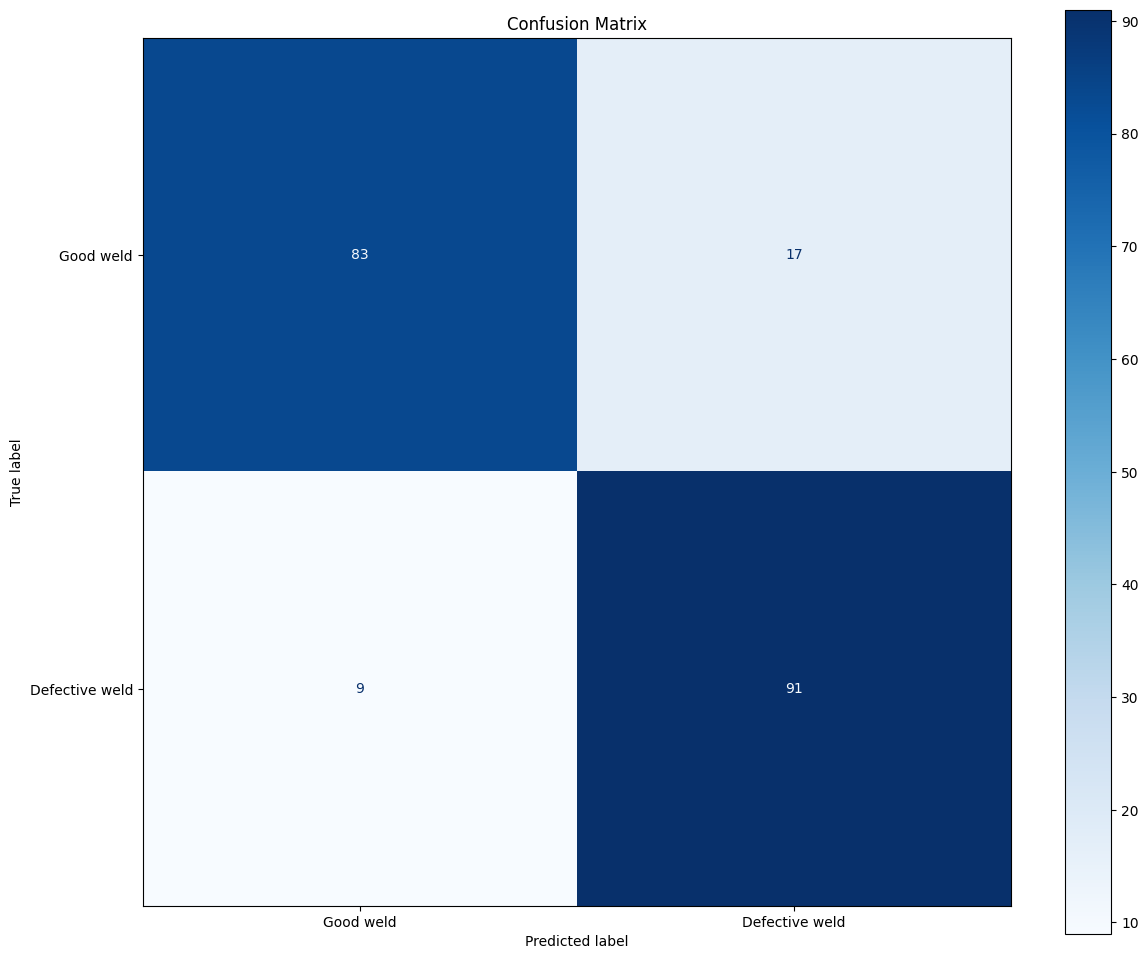

                precision    recall  f1-score   support

     Good weld       0.90      0.83      0.86       100
Defective weld       0.84      0.91      0.88       100

      accuracy                           0.87       200
     macro avg       0.87      0.87      0.87       200
  weighted avg       0.87      0.87      0.87       200



In [ ]:
simplified_labels = ["Good weld", "Defective weld"]
alt_gold_labels = [False if x == 0 else True for x in gold_labels]
alt_predicted_labels = [False if x == 0 else True for x in predicted_labels]
draw_confusion_matrix(alt_gold_labels, alt_predicted_labels, simplified_labels)
draw_classification_report(alt_gold_labels, alt_predicted_labels, simplified_labels)